## Traininig of the High Level Feature classifier with TensorFlow/Keras

**4.0 Tensorflow/Keras, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. PyArrow is used to read the data and pass it to TensorFlow.

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger
- The model is a classifier implemented as a DNN
  - Model input: 14 "high level features", described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
  - Model output: 3 classes, "W + jet", "QCD", "$t\bar{t}$"


## Load train and test datasets via PyArrow

In [1]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

# PATH = "../Data/sparkdltrigger.web.cern.ch/sparkdltrigger/"

import pyarrow.parquet as pq

testPA = pq.read_table(PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPA = pq.read_table(PATH + 'trainUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPA.num_rows
num_train = trainPA.num_rows

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are 856090 events in the test dataset
There are 3426083 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPA


pyarrow.Table
HLF_input: list<element: double not null>
  child 0, element: double not null
encoded_label: list<element: double not null>
  child 0, element: double not null
----
HLF_input: [[[0.015150733133517018,0.003511028294205839,0.874629632974455,0.00010678459789546679,0.13333333333333333,...,0.5440977822712589,0.10504238438824146,0,0,1],[0,0.003881822832783805,0.7166341448458555,0.0000883146708795798,0,...,0.15408068203867065,0.22943679241185536,0,1,0],...,[0.08797842950609695,0.015943858157778202,0.20208648628793924,0.00032192235678371085,0.4,...,4.934343603553542e-16,0.06175310087961856,0,1,0],[0.06452769243087834,0.0026548343807485165,0.035864262581626456,0.0006337920514066377,0.13333333333333333,...,4.934343603553542e-16,0.17369627941300514,0.053338028550615736,1,1]],[[0.0076626830146408935,0.007865552787224086,0.823657105059091,0.001605466344065998,0.06666666666666667,...,0.0914835471699533,0,0.14150662084748825,1,0],[0.06721212878638123,0.032790939802315136,0.1425198344908

In [4]:
# Diagnostics
pq_file = pq.ParquetFile(PATH + 'trainUndersampled_HLF_features.parquet/part-00000-89303fa0-6224-4afb-9758-195afcfec5fa-c000.snappy.parquet')

print(pq_file.metadata)
print(pq_file.metadata.row_group(0).column(0).statistics)

  created_by: parquet-mr version 1.10.1 (build a89df8f9932b6ef6633d06069e50c9b7970bebd1)
  num_columns: 2
  num_rows: 855362
  num_row_groups: 114
  format_version: 1.0
  serialized_size: 28782
  has_min_max: True
  min: 0.0
  max: 1.0
  null_count: 0
  distinct_count: None
  num_values: 105952
  physical_type: DOUBLE
  logical_type: None
  converted_type (legacy): NONE


## Convert training and test datasets from PyArrow to Numpy arrays



In [5]:
import numpy as np

X = np.stack(trainPA["HLF_input"].to_numpy())
y = np.stack(trainPA["encoded_label"].to_numpy())

X_test = np.stack(testPA["HLF_input"].to_numpy())
y_test = np.stack(testPA["encoded_label"].to_numpy())

## Create the Keras model

In [6]:
import tensorflow as tf
tf.__version__

2024-06-11 17:18:25.692223: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 17:18:25.762012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 17:18:28.937723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.16.1'

In [7]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

2024-06-11 17:18:31.389343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 17:18:31.461907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 17:18:31.462239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Tue/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-11 17:18:36.760508: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-11 17:18:36.760963: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/

## Train the model

In [9]:
batch_size = 128
n_epochs = 5

%time history = keras_model.fit(X, y, batch_size=batch_size, epochs=n_epochs, \
                                validation_data=(X_test, y_test))


Epoch 1/5


I0000 00:00:1718119125.447675    4781 service.cc:145] XLA service 0x7f05180142f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718119125.447809    4781 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-11 17:18:45.489175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-11 17:18:45.685581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   77/26767 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.4309 - loss: 1.0770 

I0000 00:00:1718119127.438740    4781 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step - accuracy: 0.8731 - loss: 0.3361 - val_accuracy: 0.9061 - val_loss: 0.2565
Epoch 2/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step - accuracy: 0.9078 - loss: 0.2499 - val_accuracy: 0.9110 - val_loss: 0.2406
Epoch 3/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9109 - loss: 0.2402 - val_accuracy: 0.9141 - val_loss: 0.2337
Epoch 4/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.9128 - loss: 0.2362 - val_accuracy: 0.9138 - val_loss: 0.2342
Epoch 5/5
26767/26767 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.9138 - loss: 0.2332 - val_accuracy: 0.9146 - val_loss: 0.2314
CPU times: user 6min 10s, sys: 1min 52s, total: 8min 3s
Wall time: 5min 20s


## Performance metrics

<IPython.core.display.Javascript object>


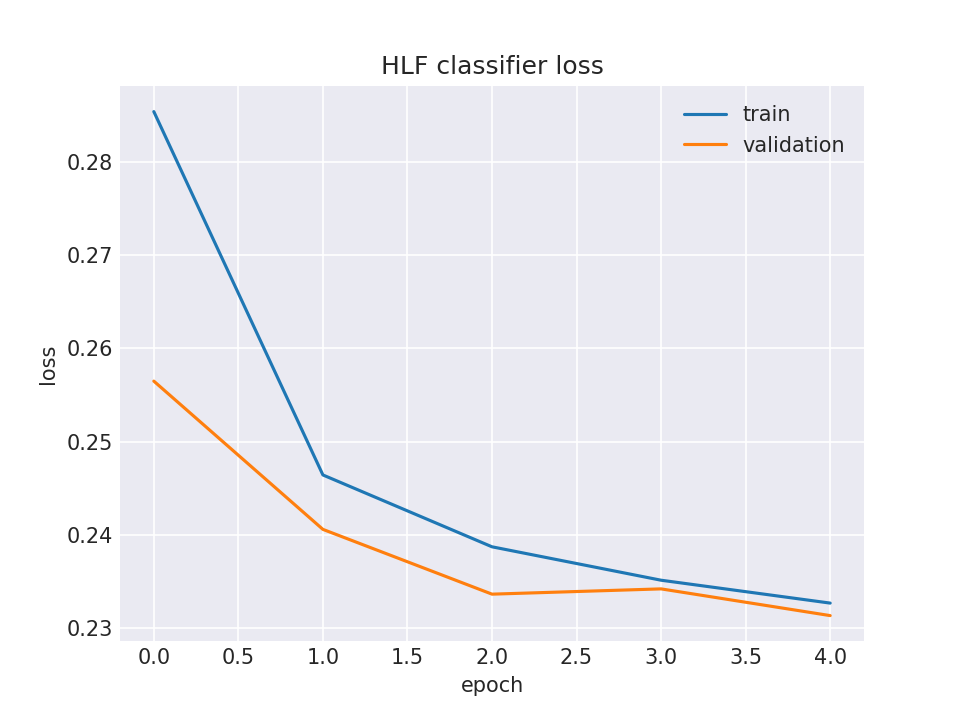

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


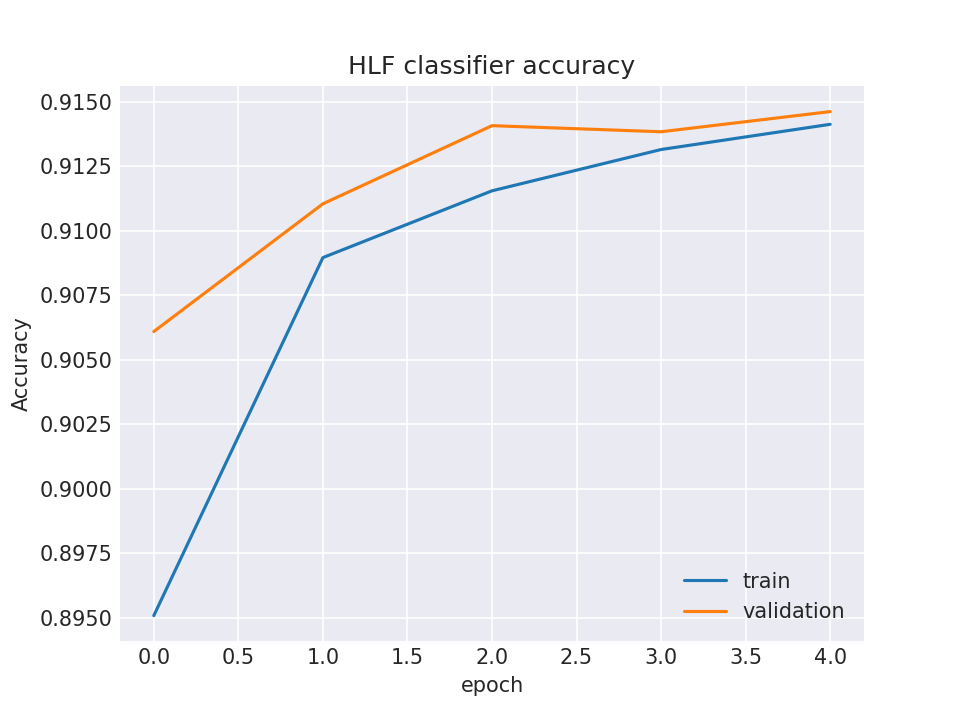

In [11]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [12]:
y_pred=history.model.predict(X_test)
y_true=y_test

26753/26753 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step


In [13]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9146


<IPython.core.display.Javascript object>


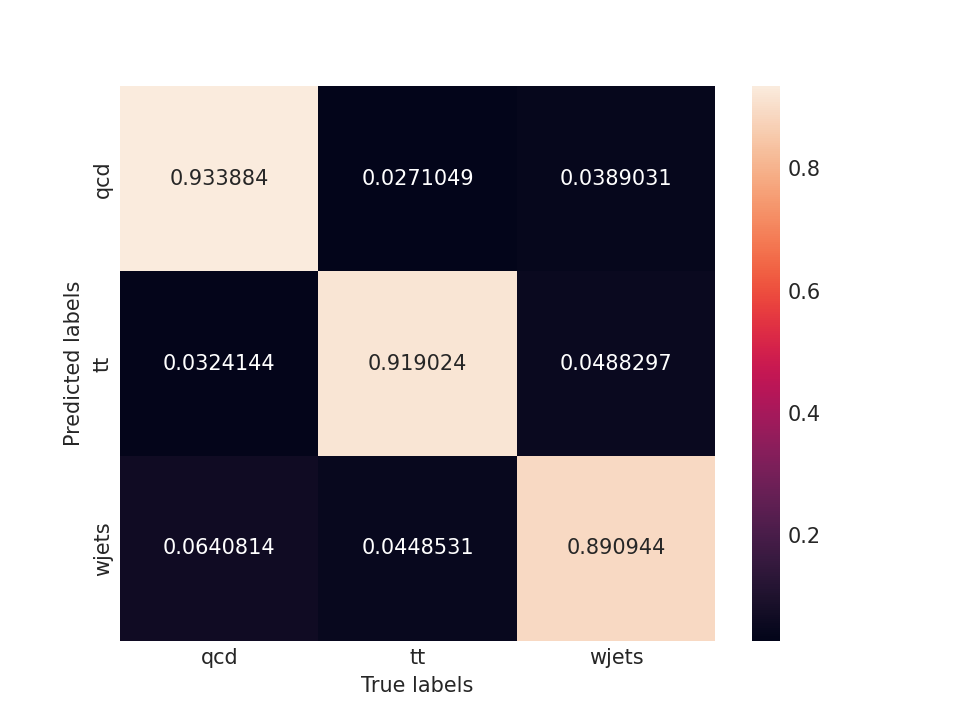

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [16]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9869157779511631, 1: 0.9852505436020591, 2: 0.9810242883380262}

<IPython.core.display.Javascript object>


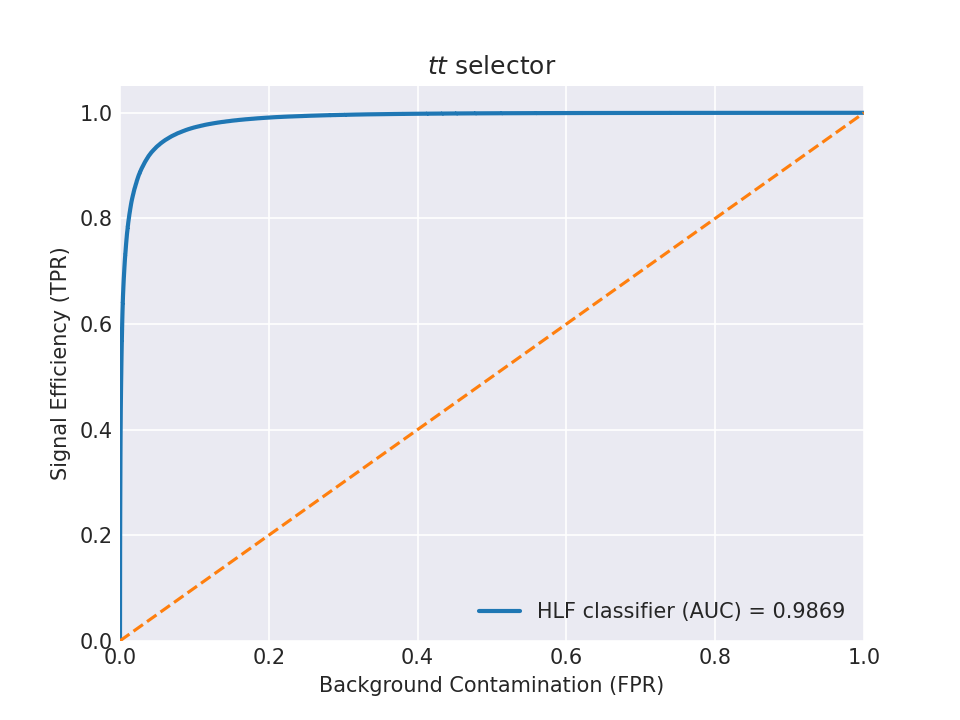

In [17]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()